In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/prototype')
from keras.layers import Input, Dense
from keras.models import Model
from keras import callbacks
import datetime

In [179]:
sample_data = pd.read_csv('sample_simulated_transaction_history.csv')

In [180]:
pd.set_option('display.max_columns', None)

In [181]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [182]:
sample_data.shape

(939512, 11)

In [183]:
sample_data.date = pd.to_datetime(sample_data.date)

In [184]:
def name_trunc(x):
    x = "_".join(x.split("_", 2)[:2])
    return x

In [185]:
sample_data.id = sample_data.id.map(lambda x:name_trunc(x))

In [186]:
df = []
depts = []
for i in sample_data.dept.unique():
    df.append(sample_data[(sample_data.dept == i)].reset_index(drop = True)[['id','date', 'purchaseamount']])
    depts.append(i)

In [187]:
sample_data.isnull().values.any()

False

In [188]:
def obtain_encoding(dataframe, depts, sample_data, pre_end_date, pre_start_date, EPOCHS, BATCH_SIZE, DIM):
    complete_data = pd.DataFrame({'date':pd.date_range(sample_data.date.min(), sample_data.date.max())})
    complete_data.set_index('date', inplace = True)
    for i in df[0].id.unique():
        specific_donor = df[0][(df[0].id == i)].reset_index(drop = True).groupby(['date']).max().drop(labels = ['id'], axis = 1).reindex(pd.date_range(sample_data.date.min(), sample_data.date.max()), fill_value = 0)
        complete_data[i] = pd.DataFrame({i:specific_donor.purchaseamount})

    xtrain = complete_data[pre_start_date:pre_end_date]
    xtrain1 = xtrain.values
    x_train = xtrain1.T

    encoding_dim = DIM
    input_mat = Input(shape=(x_train.shape[1],))
    encoded = Dense(encoding_dim, activation='linear')(input_mat)
    decoded = Dense(x_train.shape[1], activation='linear')(encoded)

    autoencoder = Model(input_mat, decoded)
    encoder = Model(input_mat, encoded)

    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])

    history = autoencoder.fit(x_train, x_train, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                   callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')])

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    plt.savefig('performance-%s.png' % depts)

    encoded_mat = encoder.predict(x_train)
    decoded_mat = decoder.predict(encoded_mat)

    new_df = pd.DataFrame(encoded_mat)
    new_df[new_df<0] = 0
    new_df.insert(loc=0, column='id', value=complete_data.columns.values)

    original = pd.DataFrame(x_train)
    original.insert(loc = 0, column = 'id', value = complete_data.columns.values)

    comparison = pd.DataFrame(decoded_mat)
    comparison[comparison<0] = 0
    comparison.insert(loc = 0, column = 'id', value = complete_data.columns.values)

    return new_df, original, comparison 

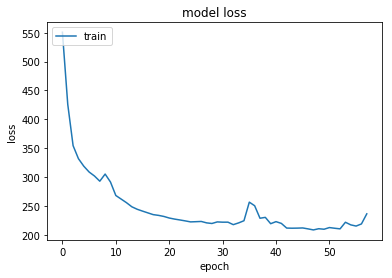

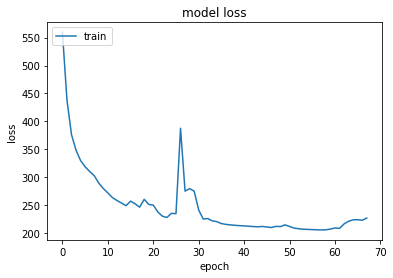

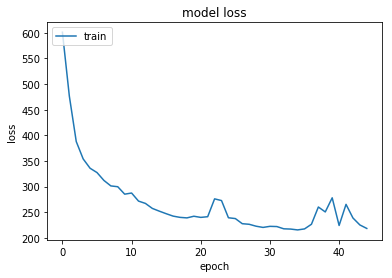

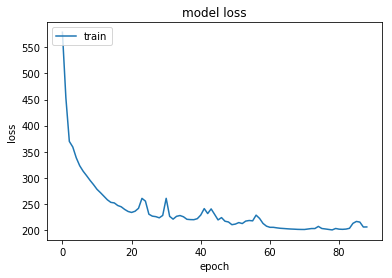

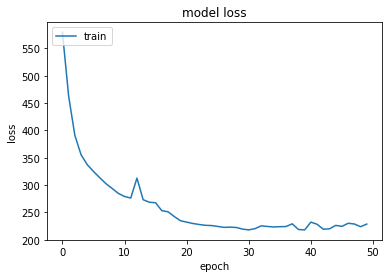

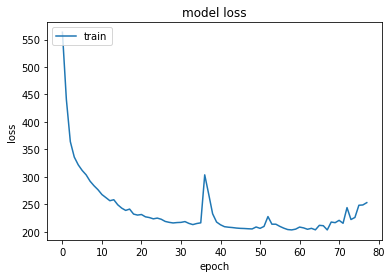

In [189]:
encod = []
original = []
compare = []
pre_start_date = '2015-01-01'
pre_end_date = '2016-01-01'
for i in range(len(df)):
    alpha, beta, gamma = obtain_encoding(df[i], depts[i], sample_data, pre_end_date, pre_start_date, EPOCHS=1000, BATCH_SIZE=500, DIM=50)
    encod.append(alpha)
    original.append(beta)
    compare.append(gamma)
    encod[-1].to_csv('encoding_of_%s_customers.csv' %depts[i], index = False)
    original[-1].to_csv('original_of_%s_customers.csv' %depts[i], index = False)
    compare[-1].to_csv('comparison_of_%s_customers.csv' %depts[i], index = False)